In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import ConvLSTM2D
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [2]:
df = pd.read_csv('Data/BTC_Daily_Six_Years_simplified.csv')
df

,close,realized_absolute_vol,datetime
0,4377.22,1.181899,2017-10-01
1,4391.48,0.325778,2017-10-02
2,4315.83,1.722654,2017-10-03
3,4219.53,2.231321,2017-10-04
4,4301.09,1.932917,2017-10-05
...,...,...,...
2232,37152.00,0.447493,2023-11-11
2233,37086.00,0.177649,2023-11-12
2234,36485.00,1.620558,2023-11-13
2235,35564.00,2.524325,2023-11-14


In [3]:
df[['close','realized_absolute_vol']].mean()

close                    20841.468529
realized_absolute_vol        2.576358
dtype: float64

In [4]:
sunday = df.iloc[::7]['realized_absolute_vol'].mean()
monday = df.iloc[1::7]['realized_absolute_vol'].mean()
tuesday = df.iloc[2::7]['realized_absolute_vol'].mean()
wednesday = df.iloc[3::7]['realized_absolute_vol'].mean()
thursday = df.iloc[4::7]['realized_absolute_vol'].mean()
friday = df.iloc[5::7]['realized_absolute_vol'].mean()
saturday = df.iloc[6::7]['realized_absolute_vol'].mean()
wednesdaytest = df.iloc[7::7]['realized_absolute_vol'].mean()
print(' Monday average vol', monday, '\n','Tuesday average vol', tuesday, '\n','Wednesday average vol', wednesday, '\n','Thursday average vol', thursday, '\n','Friday average vol', friday, '\n','Saturday average vol', saturday, '\n','Sunday average vol', sunday, '\n',)


 Monday average vol 3.0768253923964295 
 Tuesday average vol 2.6489452909116515 
 Wednesday average vol 2.8570825675712697 
 Thursday average vol 3.010997561565898 
 Friday average vol 2.6121494403229177 
 Saturday average vol 1.7429630215841305 
 Sunday average vol 2.0844117990413955 



In [5]:
# Make the index the date
df.set_index('datetime', inplace=True)
df

,close,realized_absolute_vol
datetime,,
2017-10-01,4377.22,1.181899
2017-10-02,4391.48,0.325778
2017-10-03,4315.83,1.722654
2017-10-04,4219.53,2.231321
2017-10-05,4301.09,1.932917
...,...,...
2023-11-11,37152.00,0.447493
2023-11-12,37086.00,0.177649
2023-11-13,36485.00,1.620558


In [43]:
df[-4:]

,close,realized_absolute_vol
datetime,,
2023-11-12,37086.0,0.177649
2023-11-13,36485.0,1.620558
2023-11-14,35564.0,2.524325
2023-11-15,37877.0,6.503768


In [6]:
#df.index = df.index + pd.to_timedelta("00:00:00")
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

# Add "00:00:00" to the datetime index
df.index = df.index + pd.to_timedelta("00:00:00")

In [7]:
df

,close,realized_absolute_vol
datetime,,
2017-10-01,4377.22,1.181899
2017-10-02,4391.48,0.325778
2017-10-03,4315.83,1.722654
2017-10-04,4219.53,2.231321
2017-10-05,4301.09,1.932917
...,...,...
2023-11-11,37152.00,0.447493
2023-11-12,37086.00,0.177649
2023-11-13,36485.00,1.620558


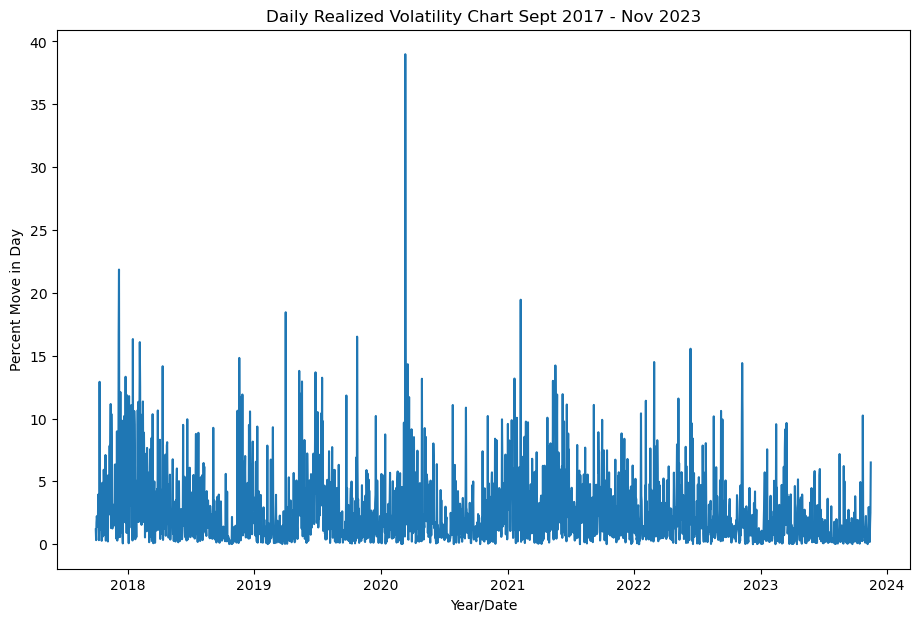

In [8]:
#plt.plot(df['close'])
plt.figure(figsize=(11, 7))

# Plot the data
plt.plot(df['realized_absolute_vol'])
plt.xlabel('Year/Date')
plt.ylabel('Percent Move in Day')
plt.title('Daily Realized Volatility Chart Sept 2017 - Nov 2023')
plt.show()


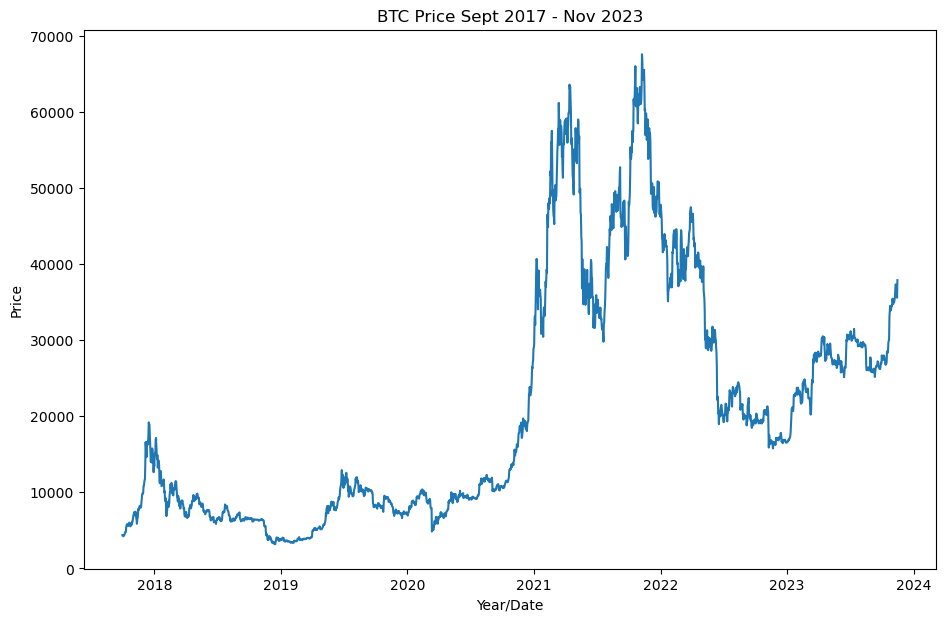

In [9]:
#plt.plot(df['close'])
plt.figure(figsize=(11, 7))

# Plot the data
plt.plot(df['close'])
plt.xlabel('Year/Date')
plt.ylabel('Price')
plt.title('BTC Price Sept 2017 - Nov 2023')
plt.show()


In [10]:
print(df.nlargest(5, 'realized_absolute_vol'))

               close  realized_absolute_vol
datetime                                   
2020-03-12   4841.67              38.980058
2017-12-07  16599.99              21.848203
2021-02-08  46416.45              19.450265
2019-04-02   4899.63              18.453843
2017-12-06  13623.50              16.669521


In [11]:
print(df.nsmallest(5, 'realized_absolute_vol'))

               close  realized_absolute_vol
datetime                                   
2022-12-10  17128.00               0.000000
2022-01-15  43102.01               0.000789
2021-07-29  40037.51               0.002972
2023-02-13  21790.00               0.004589
2021-10-14  57371.58               0.005177


In [12]:
df_realized = df.loc[:, ['realized_absolute_vol']]

In [13]:
df_realized

,realized_absolute_vol
datetime,
2017-10-01,1.181899
2017-10-02,0.325778
2017-10-03,1.722654
2017-10-04,2.231321
2017-10-05,1.932917
...,...
2023-11-11,0.447493
2023-11-12,0.177649
2023-11-13,1.620558


In [14]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_realized)
pvalue

3.899858058464142e-06

In [15]:
# Make data stationary
df_diff_realized = df_realized.diff().dropna()
df_diff_realized

,realized_absolute_vol
datetime,
2017-10-02,-0.856121
2017-10-03,1.396876
2017-10-04,0.508667
2017-10-05,-0.298404
2017-10-06,-0.494677
...,...
2023-11-11,-1.258554
2023-11-12,-0.269845
2023-11-13,1.442909


<Figure size 1200x600 with 0 Axes>

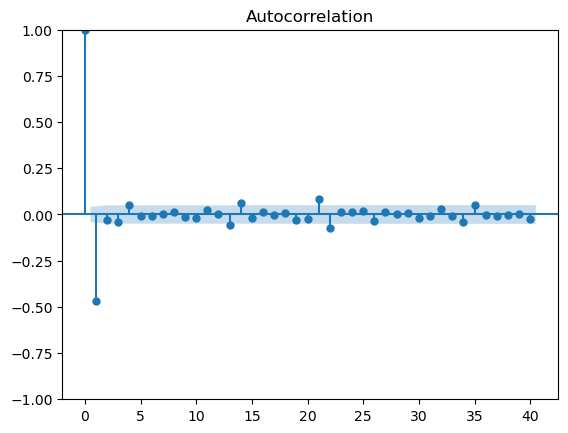

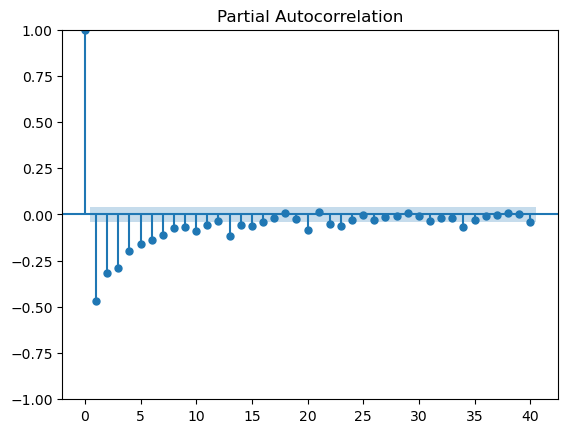

In [16]:
# Plot ACF and PACF plots to determine the order of ARIMA (p, d, q)
plt.figure(figsize=(12, 6))
plot_acf(df_diff_realized, lags=40)
plot_pacf(df_diff_realized, lags=40)
plt.show()

In [17]:
# Solve for p,d,q in our model
arima_model = auto_arima(df_realized, start_p=1, d=1, start_q=1, max_p=5, max_q=5, seasonal=False)

/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn

/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_spars

In [18]:
arima_model

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [19]:
p, d, q = (0, 1, 2)
model = ARIMA(df_realized, order=(p, d, q))
model_fit = model.fit()

/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/mikhaelhammer-bleich/anaconda3/envs/new-learn2/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [20]:
# Make forecast using ARIMA
forecast_period = 10  # Can be changed for more or less periods
forecast = model_fit.forecast(steps=forecast_period)

# Print the forecasts
print("ARIMA Forecasts:\n", forecast)

ARIMA Forecasts:
 2023-11-16    1.820234
2023-11-17    1.591910
2023-11-18    1.591910
2023-11-19    1.591910
2023-11-20    1.591910
2023-11-21    1.591910
2023-11-22    1.591910
2023-11-23    1.591910
2023-11-24    1.591910
2023-11-25    1.591910
Freq: D, Name: predicted_mean, dtype: float64


# Feed Forward NN

In [21]:
#Convert pandas dataframe to numpy array
dataset = df_realized.values
dataset = dataset.astype('float32') #Convert values to float
dataset

array([[1.1818987 ],
       [0.32577756],
       [1.7226539 ],
       ...,
       [1.6205577 ],
       [2.5243251 ],
       [6.503768  ]], dtype=float32)

In [22]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [23]:
dataset

array([[0.0303206 ],
       [0.00835754],
       [0.04419321],
       ...,
       [0.04157402],
       [0.0647594 ],
       [0.1668486 ]], dtype=float32)

In [24]:
# Take first 66% values for train and the remaining 1/3 for testing split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [25]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [26]:
#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

Shape of training set: (1465, 10)
Shape of test set: (750, 10)
Build deep model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100


2023-11-16 10:58:48.956312: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


46/46 - 0s - loss: 0.0068 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 0.0013 - 249ms/epoch - 5ms/step
Epoch 2/100
46/46 - 0s - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0013 - 50ms/epoch - 1ms/step
Epoch 3/100
46/46 - 0s - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0013 - 26ms/epoch - 572us/step
Epoch 4/100
46/46 - 0s - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0013 - 26ms/epoch - 574us/step
Epoch 5/100
46/46 - 0s - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 0.0013 - 26ms/epoch - 566us/step
Epoch 6/100
46/46 - 0s - loss: 0.0057 - acc: 0.0000e+00 - val_loss: 0.0035 - val_acc: 0.0013 - 26ms/epoch - 561us/step
Epoch 7/100
46/46 - 0s - loss: 0.0057 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0013 - 25ms/epoch - 552us/step
Epoch 8/100
46/46 - 0s - loss: 0.0056 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0013 - 27ms/epoch - 578us/step
Epoch 9/100
46/46 - 0s - loss: 0.0056 - acc: 0.0000e+00 - val_l

Epoch 70/100
46/46 - 0s - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0013 - 25ms/epoch - 547us/step
Epoch 71/100
46/46 - 0s - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0013 - 25ms/epoch - 551us/step
Epoch 72/100
46/46 - 0s - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0013 - 24ms/epoch - 524us/step
Epoch 73/100
46/46 - 0s - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0013 - 24ms/epoch - 513us/step
Epoch 74/100
46/46 - 0s - loss: 0.0037 - acc: 0.0000e+00 - val_loss: 0.0040 - val_acc: 0.0013 - 24ms/epoch - 519us/step
Epoch 75/100
46/46 - 0s - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0042 - val_acc: 0.0013 - 25ms/epoch - 537us/step
Epoch 76/100
46/46 - 0s - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0043 - val_acc: 0.0013 - 26ms/epoch - 575us/step
Epoch 77/100
46/46 - 0s - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0013 - 25ms/epoch - 549us/step
Epoch 78/100
46/46 - 0s - loss: 0.0035 -

In [28]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

24/24 [==============================] - 0s 251us/step


In [29]:
# Define the lower and upper bounds for clipping
lower_bound = 0  # Set a small non-zero lower bound
upper_bound = 100   # No upper bound (leave it as None)

# Clip the tensor to the specified range
clipped_trainPredict = tf.clip_by_value(trainPredict, lower_bound, upper_bound)
clipped_testPredict = tf.clip_by_value(testPredict, lower_bound, upper_bound)
testPredict
clipped_testPredict
clipped_trainPredict
trainPredict

array([[0.04103752],
       [0.11117881],
       [0.11738469],
       ...,
       [0.05747941],
       [0.06907135],
       [0.06830513]], dtype=float32)

In [30]:
# Estimate model performance
# Since we used minmaxscaler we can now use scaler.inverse_transform
# to invert the transformation.

trainPredict = scaler.inverse_transform(clipped_trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(clipped_testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [31]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.04 RMSE
Test Score: 2.55 RMSE


In [32]:
# shift train predictions for plotting
# we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [33]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

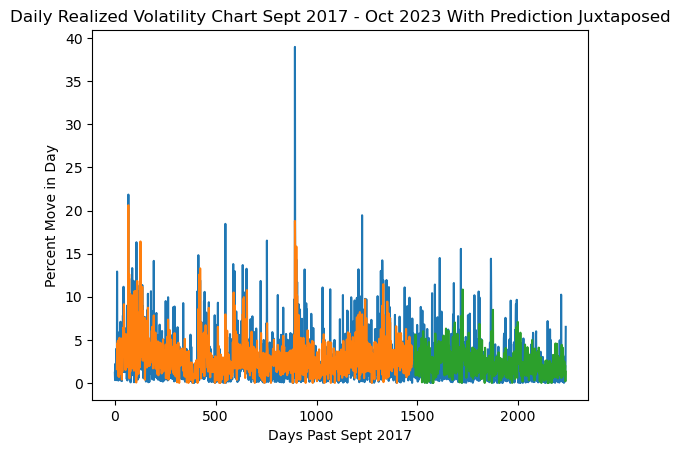

In [34]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.xlabel('Days Past Sept 2017')
plt.ylabel('Percent Move in Day')
plt.title('Daily Realized Volatility Chart Sept 2017 - Oct 2023 With Prediction Juxtaposed')

plt.show()

In [35]:
'''# Make forecast using Feed Forward NN
forecast_period = 10  
forecast = model.forecast(steps=forecast_period)

# Print the forecasts
print("ARIMA Forecasts:\n", forecast)'''

'# Make forecast using Feed Forward NN\nforecast_period = 10  \nforecast = model.forecast(steps=forecast_period)\n\n# Print the forecasts\nprint("ARIMA Forecasts:\n", forecast)'

In [36]:
# Set the sequence length for prediction
seq_size = 10  # Number of time steps to use for prediction

# Adjust the to_sequences function to create sequences of length seq_size
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

# After training the model, create an input sequence for prediction
# Use the last seq_size data points for prediction
last_sequence = dataset[-seq_size:]

# Reshape the input for prediction
last_sequence = last_sequence.reshape((1, 1, 1, 1, seq_size))

# Use the model to predict the next 10 elements
predictions = []
for _ in range(10):
    prediction = model.predict(last_sequence)
    predictions.append(prediction[0, 0])
    # Update the input sequence by shifting the values to the left and adding the new prediction
    last_sequence = np.roll(last_sequence, shift=-1)
    last_sequence[0, 0, 0, 0, -1] = prediction

# Invert the predictions to the original scale if needed
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print or use the predictions for the next 10 elements
print("Predictions for the next 10 elements:")
print(predictions)


1/1 [==============================] - 0s 7ms/step
Predictions for the next 10 elements:
[[1.09369  ]
 [2.2380204]
 [2.4381065]
 [3.212704 ]
 [2.2145703]
 [3.0473187]
 [4.463137 ]
 [3.0505633]
 [1.3134825]
 [3.7997348]]


# LSTM

In [37]:
seq_size = 10  # Number of time steps to look back 
# Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (1465, 10)
Shape of test set: (750, 10)


In [38]:
# ConvLSTM
# The layer expects input as a sequence of two-dimensional images, 
# therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Assuming you have trainX, trainY, testX, testY, and seq_size defined

# Reshape the data for ConvLSTM2D
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

# Function to create the LSTM model
def create_lstm_model(memory_bias_initializer='zeros'):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dense(1))

    # Set the bias initializer for the LSTM layer
    model.layers[0].cell.bias_initializer = {
        'forget_bias': memory_bias_initializer,
        'kernel': 'glorot_uniform',
        'recurrent': 'orthogonal'
    }
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create KerasRegressor
regressor = KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

# Define the parameter grid for the bias initializer of the LSTM layer
param_grid = {
    'memory_bias_initializer': ['zeros', 'ones', RandomNormal(mean=0.0, stddev=0.1), ...]  # Add more initializers to test
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)
grid_result = grid.fit(trainX, trainY)

# Print the best parameters found
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/var/folders/s1/pthgsjgj70vdf42p71vm7rb00000gn/T/ipykernel_69331/3836748259.py:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)


Best: -0.006142 using {'memory_bias_initializer': 'ones'}


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.initializers import RandomNormal
import numpy as np

# Assuming you have trainX, trainY, testX, testY, seq_size, and the best_params_ from GridSearchCV

# Reshape the data for ConvLSTM2D
trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

# Function to create the LSTM model with best parameters
def create_lstm_model(memory_bias_initializer='zeros'):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dense(1))

    # Set the bias initializer for the LSTM layer with the best_params_
    model.layers[0].cell.bias_initializer = best_params_['memory_bias_initializer']
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model with best parameters
model = create_lstm_model()

# Fit the model with best parameters
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=100)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


NameError: name 'best_params_' is not defined

In [ ]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:

# Define the lower and upper bounds for clipping
lower_bound = 0  # Set a small non-zero lower bound
upper_bound = 100   # No upper bound (leave it as None)

# Clip the tensor to the specified range
clipped_trainPredict = tf.clip_by_value(trainPredict, lower_bound, upper_bound)
clipped_testPredict = tf.clip_by_value(testPredict, lower_bound, upper_bound)
testPredict
clipped_testPredict
clipped_trainPredict


In [ ]:
# invert predictions back to prescaled values
# This is to compare with original input values
# Since we used minmaxscaler we can now use scaler.inverse_transform
# to invert the transformation.
trainPredict = scaler.inverse_transform(clipped_trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(clipped_testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
# we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.xlabel('Days Past Sept 2017')
plt.ylabel('Percent Move in Day')
plt.title('Daily Realized Volatility Chart Sept 2017 - Oct 2023 With Prediction Juxtaposed')
plt.show()

In [ ]:
# Set the sequence length for prediction
seq_size = 10  # Number of time steps to use for prediction

# Adjust the to_sequences function to create sequences of length seq_size
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

# After training the model, create an input sequence for prediction
# Use the last seq_size data points for prediction
last_sequence = dataset[-seq_size:]

# Reshape the input for prediction
last_sequence = last_sequence.reshape((1, 1, 1, 1, seq_size))

# Use the model to predict the next 10 elements
predictions = []
for _ in range(10):
    prediction = model.predict(last_sequence)
    predictions.append(prediction[0, 0])
    # Update the input sequence by shifting the values to the left and adding the new prediction
    last_sequence = np.roll(last_sequence, shift=-1)
    last_sequence[0, 0, 0, 0, -1] = prediction

# Invert the predictions to the original scale if needed
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print or use the predictions for the next 10 elements
print("Predictions for the next 10 elements:")
print(predictions)
